# Introduction to PowerModelsONM

**Author**:\
David M Fobes\
Deputy Group Leader\
A-1 Information Systems and Modeling Group\
[dfobes@lanl.gov](mailto:dfobes@lanl.gov)

LA-UR-25-20074

**Los Alamos National Laboratory Grid Science Winter School 2025**

This is an introduction to using PowerModelsONM, a Julia/JuMP library for optimizing the operations of networked microgrids. PowerModelsONM (ONM: Operations of Networked Microgrids), is a package designed to handle **active** distribution grids, i.e., those who may have binary decisions, like switching (topological changes) or inverter selection. It also has a more advanced MLD (maximal load delivery) formulation which contains the concept of "load blocks."

To use PowerModelsONM, you will need to install the package via `Pkg.add()`.

In [2]:
using Pkg

Pkg.activate(".")

Pkg.add("PowerModelsDistribution")
Pkg.add("PowerModelsONM")

  Activating project at `~/Library/CloudStorage/OneDrive-LosAlamosNationalLaboratory/local/working/winter-school`
   Resolving package versions...
  No Changes to `~/Library/CloudStorage/OneDrive-LosAlamosNationalLaboratory/local/working/winter-school/Project.toml`
  No Changes to `~/Library/CloudStorage/OneDrive-LosAlamosNationalLaboratory/local/working/winter-school/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Library/CloudStorage/OneDrive-LosAlamosNationalLaboratory/local/working/winter-school/Project.toml`
  No Changes to `~/Library/CloudStorage/OneDrive-LosAlamosNationalLaboratory/local/working/winter-school/Manifest.toml`


We will import PowerModelsONM with `using` so that all functions exported from ONM are available without prepending `PowerModelsONM.`, and import PowerModelsDistribution as `PMD`, in case we need some helper functions from PMD.

In [3]:
using PowerModelsONM
import PowerModelsDistribution as PMD

# Additional imports for this notebook
import Statistics: mean
import Random

When using PowerModelsONM, several solvers are already included in the package, so we do not need to explicitly add them via `Pkg.add`, more on this later.

Throughout this tutorial, we will utilize data that is included in the PowerModelsONM package as examples, so we setup a variable for the data directory `examples/data`, and some variables for file locations to make things easier.

In [4]:
begin
    onm_path = joinpath(dirname(pathof(PowerModelsONM)), "..")
    example_dir = joinpath(onm_path, "examples/data")
    ieee13_network_ex = joinpath(example_dir, "network.ieee13mod.dss")
    ieee13_settings_ex = joinpath(example_dir, "settings.ieee13mod.json")
    ieee13_events_ex = joinpath(example_dir, "events.ieee13.json")
end

"/Users/dfobes/.julia/packages/PowerModelsONM/ThIPC/src/../examples/data/events.ieee13.json"

# Test Network

Our testing network is a modification of the IEEE13 distribution network. Here we introduce the concept of load blocks, which are segments of the network that can be completely isolated from with switching actions (i.e., by opening switches).

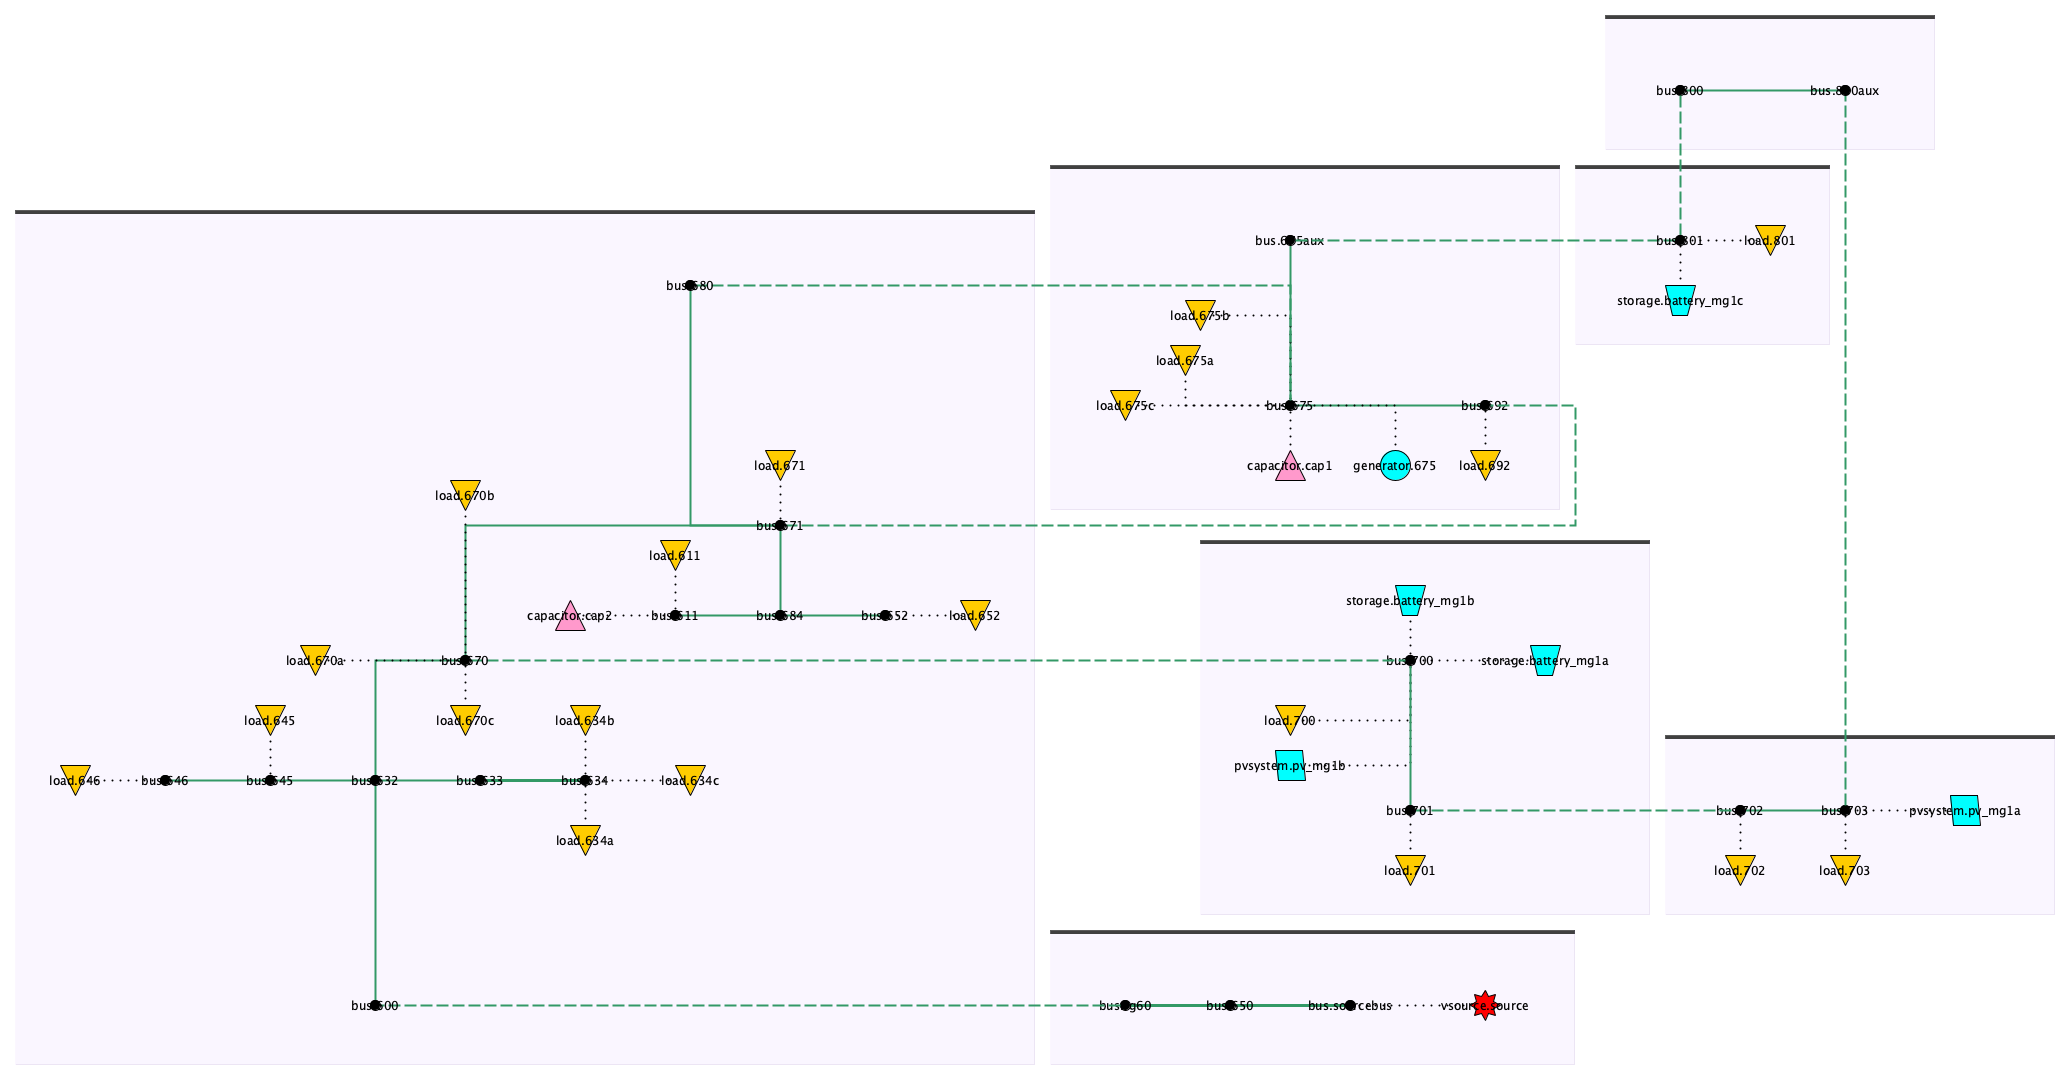

In [58]:
display("image/png", read("img/ieee13mod2.png"))

This network is fairly small, so the number of options are limited. We have also included a modified Iowa240 in the examples, but this also may not be adequate for advanced testing of algorithms. One of the biggest challenges we have is building synthetic networks with enough decision variables, and it is one of the questions we receive often from the community. 

# PowerModelsONM Uses

PowerModelsONM has two primary use cases: optimal restoration and robust partitioning. 

Optimal restoration is for generating a series of optimal actions to completely or partially restore an active distribution network following an outage, and robust partitioning is to generate sets of potential network topologies that might be resilient to future outages under load uncertainty. This notebook will focus primarily on the former, but briefly show the latter.

# Optimal Restoration

PowerModelsONM is designed to have a straightforward workflow for optimizing the operation and recovering of distribution feeders under contingencies.

In particular, the workflow consists of sequential steps of

- data processing and preparation, which includes inputs such as
  - the base network (OpenDSS format)
  - timeseries data (contained in the DSS files)
  - events data, which contains the contingencies (json, see `models/events.v1.json`)
  - settings data, which contains supplemental information about the network model not supported in DSS (json, see `models/settings.v1.json`)
  - inverters data, which contains information about inverters for stability analysis (json, see `models/inverters.v1.json` and [PowerModelsStability documentation](https://github.com/lanl-ansi/PowerModelsStability.jl)
  - faults data, which contains pre-built faults over which to iterate during fault studies (json, see `models/faults.v1.json` and [PowerModelsProtection documentation](https://github.com/lanl-ansi/PowerModelsProtection.jl)
- optimal switching (osw) / maximal load delivery (mld) problem
- optimal dispatch (OPF) problem
- fault studies via PowerModelsProtection
- stability analysis via PowerModelsStability (functionality limited)
- statistical analysis and outputs, which includes information about
  - device action timeline, such as the switch configurations at every timestep and which loads have been shed by the algorithm,
  - microgrid statistics, such as min, mean, max voltages, storage state of charge, analysis of load served, analysis of generation sources, etc.
  - Powerflow outputs, which contains dispatch setpoints and bus voltage magnitudes
  - Small signal stability results
  - Fault analysis results

Protection optimization in the ONM workflow is performed manually using Sandia National Labs' Protection Setting Optimizer tool.

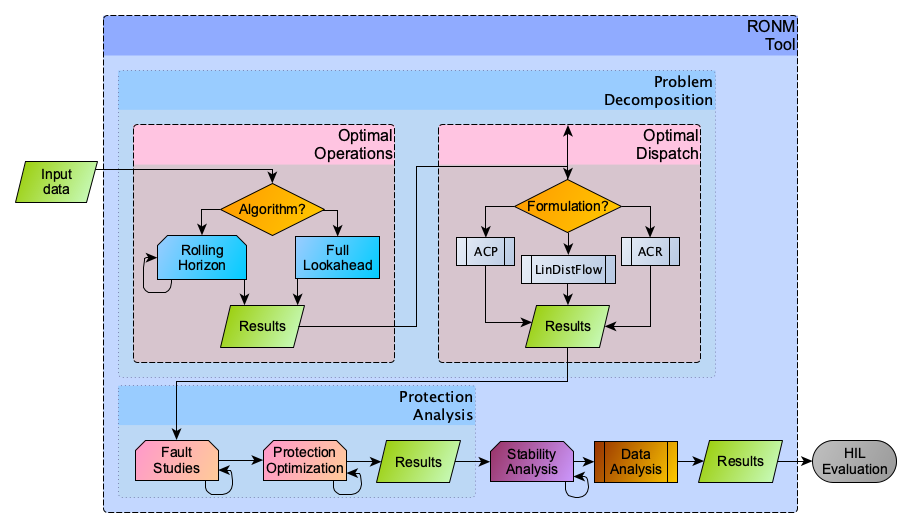

In [6]:
display("image/png", read(joinpath(onm_path, "docs/src/assets/onm_process_flow_v4.png")))

## The Problem

This is the problem definition for the optimal restoration problem:

In [60]:
"""
    build_block_mld(pm::PMD.AbstractUBFModels)

Single-network load shedding problem for Branch Flow model
"""
function dummy_build_block_mld(pm::PMD.AbstractUBFModels)
    var_opts = ref(pm, :options, "variables")
    con_opts = ref(pm, :options, "constraints")

    variable_block_indicator(pm; relax=var_opts["relax-integer-variables"])
    !con_opts["disable-grid-forming-inverter-constraint"] && variable_inverter_indicator(pm; relax=var_opts["relax-integer-variables"])

    PMD.variable_mc_bus_voltage_on_off(pm; bounded=!var_opts["unbound-voltage"])

    PMD.variable_mc_branch_current(pm; bounded=!var_opts["unbound-line-current"])
    PMD.variable_mc_branch_power(pm; bounded=!var_opts["unbound-line-power"])

    PMD.variable_mc_switch_power(pm; bounded=!var_opts["unbound-switch-power"])
    variable_switch_state(pm; relax=var_opts["relax-integer-variables"])

    PMD.variable_mc_transformer_power(pm; bounded=!var_opts["unbound-transformer-power"])
    PMD.variable_mc_oltc_transformer_tap(pm)

    PMD.variable_mc_generator_power_on_off(pm; bounded=!var_opts["unbound-generation-power"])

    variable_mc_storage_power_mi_on_off(pm; bounded=!var_opts["unbound-storage-power"], relax=var_opts["relax-integer-variables"])

    PMD.variable_mc_load_power(pm)

    PMD.variable_mc_capcontrol(pm; relax=var_opts["relax-integer-variables"])

    PMD.constraint_mc_model_current(pm)

    !con_opts["disable-grid-forming-inverter-constraint"] && constraint_grid_forming_inverter_per_cc_block(pm; relax=var_opts["relax-integer-variables"])

    if con_opts["disable-grid-forming-inverter-constraint"]
        for i in ids(pm, :ref_buses)
            PMD.constraint_mc_theta_ref(pm, i)
        end
    else
        for i in ids(pm, :bus)
            constraint_mc_inverter_theta_ref(pm, i)
        end
    end

    constraint_mc_bus_voltage_block_on_off(pm)

    for i in ids(pm, :gen)
        !var_opts["unbound-generation-power"] && constraint_mc_generator_power_block_on_off(pm, i)
    end

    for i in ids(pm, :load)
        constraint_mc_load_power_block_on_off(pm, i)
    end

    for i in ids(pm, :bus)
        constraint_mc_power_balance_shed_block(pm, i)
    end

    for i in ids(pm, :storage)
        PMD.constraint_storage_state(pm, i)
        constraint_storage_complementarity_mi_block_on_off(pm, i)
        constraint_mc_storage_block_on_off(pm, i)
        constraint_mc_storage_losses_block_on_off(pm, i)
        !con_opts["disable-thermal-limit-constraints"] && !var_opts["unbound-storage-power"] && PMD.constraint_mc_storage_thermal_limit(pm, i)
        !con_opts["disable-storage-unbalance-constraint"] && constraint_mc_storage_phase_unbalance_grid_following(pm, i)
    end

    for i in ids(pm, :branch)
        PMD.constraint_mc_power_losses(pm, i)
        PMD.constraint_mc_model_voltage_magnitude_difference(pm, i)
        PMD.constraint_mc_voltage_angle_difference(pm, i)

        !con_opts["disable-thermal-limit-constraints"] && PMD.constraint_mc_thermal_limit_from(pm, i)
        !con_opts["disable-thermal-limit-constraints"] && PMD.constraint_mc_thermal_limit_to(pm, i)

        !con_opts["disable-current-limit-constraints"] && PMD.constraint_mc_ampacity_from(pm, i)
        !con_opts["disable-current-limit-constraints"] && PMD.constraint_mc_ampacity_to(pm, i)
    end

    !con_opts["disable-switch-close-action-limit"] && constraint_switch_close_action_limit(pm)
    con_opts["disable-microgrid-networking"] &&  constraint_disable_networking(pm; relax=var_opts["relax-integer-variables"])
    !con_opts["disable-radiality-constraint"] && constraint_radial_topology(pm; relax=var_opts["relax-integer-variables"])
    !con_opts["disable-block-isolation-constraint"] && constraint_isolate_block(pm)
    for i in ids(pm, :switch)
        constraint_mc_switch_state_open_close(pm, i)

        !con_opts["disable-thermal-limit-constraints"] && PMD.constraint_mc_switch_thermal_limit(pm, i)
        !con_opts["disable-current-limit-constraints"] && PMD.constraint_mc_switch_ampacity(pm, i)
    end

    for i in ids(pm, :transformer)
        constraint_mc_transformer_power_block_on_off(pm, i; fix_taps=false)
    end

    objective_min_shed_load_block_rolling_horizon(pm)
end

dummy_build_block_mld

## Inputs

Current under development and coming soon is a new network data representation in JSON based on the Common Information Model format called RAVENS. This format will integrate the information typically contained in network definition files with the additional data required that is also shown below. More information can be found at [MG-RAVENS](https://github.com/lanl-ansi/MG-RAVENS).

### Network

The first and foremost piece of data you will need is the network definition files in OpenDSS format. For more information on what is currently supported see [PowerModelsDistribution](https://github.com/lanl-ansi/PowerModelsDistribution.jl).

Let's load the ieee13mod case:

In [61]:
base_network = parse_file(ieee13_network_ex)

Dict{String, Any} with 21 entries:
  "recloser"                => Dict{String, Any}("671700"=>Dict{String, Any}("l…
  "is_kron_reduced"         => true
  "conductor_ids"           => [1, 2, 3]
  "bus"                     => Dict{String, Any}("800aux"=>Dict{String, Any}("r…
  "name"                    => "ieee13nodeckt"
  "settings"                => Dict{String, Any}("sbase_default"=>1000.0, "vbas…
  "files"                   => ["/Users/dfobes/.julia/packages/PowerModelsONM/T…
  "switch_close_actions_ub" => Inf
  "storage"                 => Dict{String, Any}("battery_mg1a"=>Dict{String, A…
  "switch"                  => Dict{String, Any}("cb_101"=>Dict{String, Any}("c…
  "generator"               => Dict{String, Any}("675"=>Dict{String, Any}("vg"=…
  "dss_options"             => DssOptions("%growth"=>2.5, "%mean"=>65.0, "%norm…
  "time_series"             => Dict{String, Any}("microgrid1a"=>Dict{String, An…
  "voltage_source"          => Dict{String, Any}("source"=>Dict{String, Any}(

However, for network restoration **sequences**, we actually need a multinetwork representation:

In [62]:
network = make_multinetwork(base_network)

Dict{String, Any} with 7 entries:
  "name"         => "ieee13nodeckt"
  "files"        => ["/Users/dfobes/.julia/packages/PowerModelsONM/ThIPC/src/..…
  "multinetwork" => true
  "dss_options"  => DssOptions("%growth"=>2.5, "%mean"=>65.0, "%normal"=>100.0,…
  "nw"           => Dict{String, Any}("3"=>Dict{String, Any}("recloser"=>Dict{S…
  "mn_lookup"    => Dict("8"=>7.0, "4"=>3.0, "1"=>0.0, "5"=>4.0, "2"=>1.0, "6"=…
  "data_model"   => ENGINEERING

Multinetworks are data structures which contains a full network definition under `"nw"` with the time varying values written directly to that copy.

Each "subnetwork", which in this case is just a timestep, will be indexed by the string representation of an integer, in order.

For example, the timestep named `"2"`, which corresponds in this case to timestep `2.0` (which you can find under `"mn_lookup"`), can be explored like this:

In [63]:
network["nw"]["2"]

Dict{String, Any} with 19 entries:
  "recloser"                => Dict{String, Any}("671700"=>Dict{String, Any}("l…
  "is_kron_reduced"         => true
  "voltage_source"          => Dict{String, Any}("source"=>Dict{String, Any}("s…
  "conductor_ids"           => [1, 2, 3]
  "time"                    => 1.0
  "line"                    => Dict{String, Any}("632670"=>Dict{String, Any}("c…
  "time_elapsed"            => 1.0
  "relay"                   => Dict{String, Any}("801675"=>Dict{String, Any}("l…
  "bus"                     => Dict{String, Any}("800aux"=>Dict{String, Any}("r…
  "settings"                => Dict{String, Any}("sbase_default"=>1000.0, "vbas…
  "transformer"             => Dict{String, Any}("xfm1"=>Dict{String, Any}("pol…
  "switch_close_actions_ub" => Inf
  "shunt"                   => Dict{String, Any}("cap1"=>Dict{String, Any}("sou…
  "storage"                 => Dict{String, Any}("battery_mg1a"=>Dict{String, A…
  "switch"                  => Dict{String, Any}("cb_1

`make_multinetwork` will look for `time_series` data and expand the network data into this more verbose representation.

Alternatively, using `parse_network` will return a `base_network, network` tuple

In [64]:
(base_network, network) = parse_network(ieee13_network_ex)

(Dict{String, Any}("recloser" => Dict{String, Any}("671700" => Dict{String, Any}("location" => "line.671700", "monitor_type" => "line")), "is_kron_reduced" => true, "conductor_ids" => [1, 2, 3], "bus" => Dict{String, Any}("800aux" => Dict{String, Any}("rg" => Float64[], "grounded" => Int64[], "status" => ENABLED, "terminals" => [1, 2, 3], "xg" => Float64[]), "671" => Dict{String, Any}("rg" => Float64[], "grounded" => Int64[], "status" => ENABLED, "terminals" => [1, 2, 3], "xg" => Float64[]), "800" => Dict{String, Any}("rg" => Float64[], "grounded" => Int64[], "status" => ENABLED, "terminals" => [1, 2, 3], "xg" => Float64[]), "680" => Dict{String, Any}("rg" => Float64[], "grounded" => Int64[], "status" => ENABLED, "terminals" => [1, 2, 3], "xg" => Float64[]), "634" => Dict{String, Any}("rg" => Float64[], "grounded" => Int64[], "status" => ENABLED, "terminals" => [1, 2, 3], "xg" => Float64[]), "652" => Dict{String, Any}("rg" => Float64[], "grounded" => Int64[], "status" => ENABLED, "term

### Settings

There are many things that cannot be easily represented in the DSS specification, specifically relating to optimization bounds, which is not the use case for OpenDSS. To support specifying these extra types of settings, we created a settings JSON Schema.

In this example, we load some settings that have been found to fit the loaded data model well.

In [65]:
settings = parse_settings(ieee13_settings_ex)

Dict{String, Any} with 14 entries:
  "voltage_source" => Dict{String, Any}("source"=>Dict{String, Any}("qg_lb"=>[0…
  "line"           => Dict{String, Any}("632670"=>Dict{String, Any}("vad_ub"=>[…
  "bus"            => Dict{String, Any}("646"=>Dict{String, Any}("vm_ub"=>[2.64…
  "options"        => Dict{String, Any}("data"=>Dict{String, Any}("time-elapsed…
  "solvers"        => Dict{String, Any}("HiGHS"=>Dict{String, Any}("presolve"=>…
  "settings"       => Dict{String, Any}("sbase_default"=>1000.0)
  "transformer"    => Dict{String, Any}("xfm1"=>Dict{String, Any}("sm_ub"=>2500…
  "shunt"          => Dict{String, Any}()
  "solar"          => Dict{String, Any}()
  "storage"        => Dict{String, Any}("battery_mg1a"=>Dict{String, Any}("phas…
  "switch"         => Dict{String, Any}("cb_101"=>Dict{String, Any}("cm_ub"=>[I…
  "generator"      => Dict{String, Any}()
  "dss"            => Dict{String, Any}("Storage.Battery_mg1b"=>Dict{String, An…
  "load"           => Dict{String, Any}("634a

Alternatively, we can use the `build_settings` helper function to generate these settings files with some reasonable defaults, which can be edited further. Note that `build_settings` is deprecated in favor of `build_settings_new`, and the former will be replace by the latter in the next major version release. The features are the same, but the interface is slightly different.

In [66]:
settings_from_build_settings = build_settings_new(
	base_network;
	vm_lb_pu=0.8,
	vm_ub_pu=1.2,
	vad_deg=5.0,
	switch_close_actions_ub=1
)

Dict{String, Any} with 5 entries:
  "options" => Dict{String, Any}("outputs"=>Dict{String, Any}("log-level"=>"war…
  "line"    => Dict{String, Any}("632670"=>Dict{String, Any}("vad_ub"=>[5.0, 5.…
  "solvers" => Dict{String, Any}("HiGHS"=>Dict{String, Any}("presolve"=>"choose…
  "switch"  => Dict{String, Any}("cb_101"=>Dict{String, Any}("cm_ub"=>[1000.0, …
  "bus"     => Dict{String, Any}("646"=>Dict{String, Any}("vm_ub"=>[2.88213, 2.…

Settings can be easily applied via `apply_settings`, which will return a copy of the network data structure.

It should be noted that settings are applied to the `base_network`, i.e., not the multinetwork data structure.

In [67]:
base_network_settings = apply_settings(base_network, settings)

Dict{String, Any} with 24 entries:
  "recloser"                => Dict{String, Any}("671700"=>Dict{String, Any}("l…
  "is_kron_reduced"         => true
  "conductor_ids"           => [1, 2, 3]
  "time_elapsed"            => [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  "bus"                     => Dict{String, Any}("800"=>Dict{String, Any}("rg"=…
  "name"                    => "ieee13nodeckt"
  "solvers"                 => Dict{String, Any}("HiGHS"=>Dict{String, Any}("pr…
  "settings"                => Dict{String, Any}("sbase_default"=>1000.0, "vbas…
  "files"                   => ["/Users/dfobes/.julia/packages/PowerModelsONM/T…
  "switch_close_actions_ub" => [1, 1, 1, 1, 1, 1, 1, 1]
  "storage"                 => Dict{String, Any}("battery_mg1a"=>Dict{String, A…
  "switch"                  => Dict{String, Any}("801675"=>Dict{String, Any}("c…
  "generator"               => Dict{String, Any}("675"=>Dict{String, Any}("pg"=…
  "dss_options"             => DssOptions("%growth"=>2.5, "%mean"

It is necessary to rebuild the multinetwork data structure after applying settings.

In [68]:
network_settings = make_multinetwork(base_network_settings)

Dict{String, Any} with 9 entries:
  "options"      => Dict{String, Any}("data"=>Dict{String, Any}("time-elapsed"=…
  "name"         => "ieee13nodeckt"
  "solvers"      => Dict{String, Any}("HiGHS"=>Dict{String, Any}("presolve"=>"c…
  "files"        => ["/Users/dfobes/.julia/packages/PowerModelsONM/ThIPC/src/..…
  "multinetwork" => true
  "dss_options"  => DssOptions("%growth"=>2.5, "%mean"=>65.0, "%normal"=>100.0,…
  "nw"           => Dict{String, Any}("3"=>Dict{String, Any}("recloser"=>Dict{S…
  "mn_lookup"    => Dict("8"=>7.0, "4"=>3.0, "1"=>0.0, "5"=>4.0, "2"=>1.0, "6"=…
  "data_model"   => ENGINEERING

#### Common Issue with Settings

There is a common problem with settings when working with single network (non-multinetwork) data. By default, `time_elapsed` and `switch_close_actions_ub` will populate with vectors of length of the `time_series` data, so if you're working with this base network, that might need to be corrected:

In [69]:
base_network_settings["time_elapsed"] = base_network_settings["time_elapsed"][1]

1.0

In [70]:
base_network_settings["switch_close_actions_ub"] = base_network_settings["switch_close_actions_ub"][1]

1

### Contingencies (Events)

To apply a contingency to a network, we need to define a contingency using the events schema.

In this example, we load a contingency where in timestep 1 a switching action isolates a microgrid, and ensures that another switch always stays closed (because it is a fuse).

In [71]:
raw_events = parse_events(ieee13_events_ex)

12-element Vector{Dict{String, Any}}:
 Dict("event_data" => Dict{String, Any}("status" => 1, "dispatchable" => false, "state" => "open"), "timestep" => 1, "affected_asset" => "line.671692", "event_type" => "switch")
 Dict("event_data" => Dict{String, Any}("status" => "ENABLED", "dispatchable" => "NO", "state" => "OPEN"), "timestep" => 1, "affected_asset" => "line.671700", "event_type" => "switch")
 Dict("event_data" => Dict{String, Any}("status" => "ENABLED", "dispatchable" => "NO", "state" => "OPEN"), "timestep" => 1, "affected_asset" => "line.701702", "event_type" => "switch")
 Dict("event_data" => Dict{String, Any}("status" => "ENABLED", "dispatchable" => "NO", "state" => "OPEN"), "timestep" => 1, "affected_asset" => "line.703800", "event_type" => "switch")
 Dict("event_data" => Dict{String, Any}("status" => "ENABLED", "dispatchable" => "NO", "state" => "OPEN"), "timestep" => 1, "affected_asset" => "line.800801", "event_type" => "switch")
 Dict("event_data" => Dict{String, Any}("sta

These events are "raw events", in that they have not yet been parsed into the native network data format. These raw events are a vector, in order, that defines a sequence of events.

To parse the events into the native format, we need to have the network data

In [72]:
events = parse_events(raw_events, network)

Dict{String, Any} with 2 entries:
  "1" => Dict{String, Any}("switch"=>Dict{String, Any}("801675"=>Dict{String, A…
  "2" => Dict{String, Any}("switch"=>Dict{String, Any}("801675"=>Dict{String, A…

As you can see, this structure now looks much more like the native network definition, allowing you to see how we parse events into actual actions in the timeseries representation.

The first thing that happens in this contingency is that all switches `OPEN` and become inoperable (`"dispatchable"=>NO`) at the timestep that they open. This is the islanding stage. Typically, we keep switches in this state for at least one timestep to ensure stability. You can change the length of the timestep to be arbitrarily short if desired; this aspect is meant to be flexible.

In [73]:
events["1"]["switch"]

Dict{String, Any} with 6 entries:
  "801675" => Dict{String, Any}("status"=>ENABLED, "dispatchable"=>NO, "state"=…
  "671692" => Dict{String, Any}("status"=>ENABLED, "dispatchable"=>NO, "state"=…
  "671700" => Dict{String, Any}("status"=>ENABLED, "dispatchable"=>NO, "state"=…
  "703800" => Dict{String, Any}("status"=>ENABLED, "dispatchable"=>NO, "state"=…
  "701702" => Dict{String, Any}("status"=>ENABLED, "dispatchable"=>NO, "state"=…
  "800801" => Dict{String, Any}("status"=>ENABLED, "dispatchable"=>NO, "state"=…

In this case, in the second timestep, we allow the switches to be operable again (). switches will be available to the algorithm in the same time step as they are enabled (`"dispatchable"=>YES`).

In [74]:
events["2"]["switch"]

Dict{String, Any} with 6 entries:
  "801675" => Dict{String, Any}("dispatchable"=>YES)
  "671700" => Dict{String, Any}("dispatchable"=>YES)
  "671692" => Dict{String, Any}("dispatchable"=>YES)
  "703800" => Dict{String, Any}("dispatchable"=>YES)
  "701702" => Dict{String, Any}("dispatchable"=>YES)
  "800801" => Dict{String, Any}("dispatchable"=>YES)

To apply these events to a network, we can use `apply_events`, which will return a copy of the original network data structure.

In [75]:
network_settings_events = apply_events(network_settings, events)

Dict{String, Any} with 9 entries:
  "options"      => Dict{String, Any}("outputs"=>Dict{String, Any}("log-level"=…
  "name"         => "ieee13nodeckt"
  "solvers"      => Dict{String, Any}("HiGHS"=>Dict{String, Any}("mip_heuristic…
  "files"        => ["/Users/dfobes/.julia/packages/PowerModelsONM/ThIPC/src/..…
  "multinetwork" => true
  "dss_options"  => DssOptions("%growth"=>2.5, "%mean"=>65.0, "%normal"=>100.0,…
  "nw"           => Dict{String, Any}("8"=>Dict{String, Any}("recloser"=>Dict{S…
  "mn_lookup"    => Dict("3"=>2.0, "4"=>3.0, "1"=>0.0, "5"=>4.0, "2"=>1.0, "6"=…
  "data_model"   => ENGINEERING

Like with settings, we can use a useful helper function `build_events` to create a simple events file with some reasonable defults.

In [76]:
events_from_build_events = build_events(base_network)

7-element Vector{Dict{String, Any}}:
 Dict("event_data" => Dict{String, Any}("status" => "ENABLED", "dispatchable" => "YES", "state" => "CLOSED"), "timestep" => 1, "affected_asset" => "line.cb_101", "event_type" => "switch")
 Dict("event_data" => Dict{String, Any}("status" => "DISABLED", "dispatchable" => "YES", "state" => "CLOSED"), "timestep" => 1, "affected_asset" => "line.801675", "event_type" => "switch")
 Dict("event_data" => Dict{String, Any}("status" => "ENABLED", "dispatchable" => "YES", "state" => "CLOSED"), "timestep" => 1, "affected_asset" => "line.671692", "event_type" => "switch")
 Dict("event_data" => Dict{String, Any}("status" => "ENABLED", "dispatchable" => "YES", "state" => "CLOSED"), "timestep" => 1, "affected_asset" => "line.671700", "event_type" => "switch")
 Dict("event_data" => Dict{String, Any}("status" => "ENABLED", "dispatchable" => "YES", "state" => "CLOSED"), "timestep" => 1, "affected_asset" => "line.703800", "event_type" => "switch")
 Dict("event_data" => 

There are actually two types of events, `"switch"` and `"fault"`, but they both have the same pratical effect: they operate on switches. A `"fault"` event will cause a switch or multiple switches to open to isolate the fault. In practice, we usually use the `"switch"` `event_type` to have fine grained control over the progression of the event.

### Optimization Solvers

In order to actually solve any of the optimization problems within PowerModelsONM, you will need to initialize some optimization solvers.

PowerModelsONM has several solvers built-in in case you don't want to create your own, and can be created with `build_solver_instances`, which will ouput a Dictionary with

- `"nlp_solver"`: Ipopt
- `"mip_solver"`: HiGHS
- `"lp_solver"`: HiGHS
- `"minlp_solver"`: Juniper
- `"misocp_solver"`: Juniper


To create some solvers, it is useful to have some solver settings. The settings structure contains some reasonable defaults.

In [77]:
settings["solvers"]

Dict{String, Any} with 7 entries:
  "HiGHS"     => Dict{String, Any}("presolve"=>"choose", "mip_feasibility_toler…
  "KNITRO"    => Dict{String, Any}("presolve"=>1, "opttol"=>0.0001, "algorithm"…
  "useGurobi" => false
  "Juniper"   => Dict{String, Any}("branch_strategy"=>:StrongPseuoCost, "allow_…
  "Ipopt"     => Dict{String, Any}("tol"=>1.0e-6, "mu_strategy"=>"adaptive", "p…
  "Gurobi"    => Dict{String, Any}("FeasibilityTol"=>1.0e-6, "MIPGap"=>0.0001, …
  "useKNITRO" => false

In particular, let's look at the settings for HiGHS, which we have found requires a few tweaks to work with this problem type:

In [78]:
settings["solvers"]["HiGHS"]

Dict{String, Any} with 9 entries:
  "presolve"                      => "choose"
  "mip_feasibility_tolerance"     => 1.0e-6
  "primal_feasibility_tolerance"  => 1.0e-5
  "dual_feasibility_tolerance"    => 1.0e-5
  "mip_rel_gap"                   => 0.0001
  "output_flag"                   => false
  "mip_heuristic_effort"          => 0.15
  "small_matrix_value"            => 1.0e-12
  "allow_unbounded_or_infeasible" => true

We can now build some solver instances with these settings:

In [79]:
solvers = build_solver_instances(; solver_options=settings["solvers"])

Dict{String, Any} with 5 entries:
  "mip_solver"    => OptimizerWithAttributes(Optimizer, Pair{AbstractOptimizerA…
  "nlp_solver"    => OptimizerWithAttributes(Optimizer, Pair{AbstractOptimizerA…
  "minlp_solver"  => OptimizerWithAttributes(Optimizer, Pair{AbstractOptimizerA…
  "lp_solver"     => OptimizerWithAttributes(Optimizer, Pair{AbstractOptimizerA…
  "misocp_solver" => OptimizerWithAttributes(Optimizer, Pair{AbstractOptimizerA…

## Optimal Switching Problem

Now that we have a network with contingencies and settings applied, we want to solve a optimal switching / mld problem.

**First**, it should be noted that because loads are most typically not individually controllable in distribution feeders, with a few notable exceptions, loads must largely be shed by isolating a load block with switching actions. A load block is defined as a block of buses which can be fully isolated from the grid by opening one or more _operable_ switches.

To accomodate this reality, we extended PowerModelsDistribution by adding the ability to assign load status variables to multiple loads (_i.e._, by block), and adding constraints that isolate blocks of load that are desired to be shed to maintain operability of the rest of the grid.

**Second**, the optimal switching problem currently uses the LinDist3Flow model (`PowerModelsDistribution.LPUBFDiagModel`), which is a quadratic approximation, due to the presence of mixed integers.

**Finally**, the optimial switching problem currently solves sequentially, rather than globally over the entire multinetwork, which means switch configurations and storage energies are manually updated after each timestep is solved.

To run the optimal switching problem, use `optimize_switches`

In [80]:
optimal_switching_results = optimize_switches(network_settings_events, solvers["mip_solver"]; algorithm="rolling-horizon")

Dict{String, Any} with 8 entries:
  "8" => Dict{String, Any}("solve_time"=>0.0300197, "optimizer"=>"HiGHS", "term…
  "4" => Dict{String, Any}("solve_time"=>0.0340633, "optimizer"=>"HiGHS", "term…
  "1" => Dict{String, Any}("solve_time"=>0.0107647, "optimizer"=>"HiGHS", "term…
  "5" => Dict{String, Any}("solve_time"=>0.0654426, "optimizer"=>"HiGHS", "term…
  "2" => Dict{String, Any}("solve_time"=>0.143791, "optimizer"=>"HiGHS", "termi…
  "6" => Dict{String, Any}("solve_time"=>0.0743779, "optimizer"=>"HiGHS", "term…
  "7" => Dict{String, Any}("solve_time"=>0.0291692, "optimizer"=>"HiGHS", "term…
  "3" => Dict{String, Any}("solve_time"=>0.0807628, "optimizer"=>"HiGHS", "term…

The result is a dictionary, indexed by the subnetwork indexes discussed before, with the results of each timestep, where the actual solution is contained under `"solution"`.

In [81]:
optimal_switching_results["1"]

Dict{String, Any} with 9 entries:
  "solve_time"         => 0.0107647
  "optimizer"          => "HiGHS"
  "termination_status" => OPTIMAL
  "dual_status"        => NO_SOLUTION
  "primal_status"      => FEASIBLE_POINT
  "objective"          => 25.496
  "solution"           => Dict{String, Any}("voltage_source"=>Dict{String, Any}…
  "mip_gap"            => 0.0
  "objective_lb"       => 25.496

In [82]:
optimal_switching_results["1"]["solution"]

Dict{String, Any} with 12 entries:
  "voltage_source" => Dict{String, Any}("source"=>Dict{String, Any}("qg"=>[795.…
  "line"           => Dict{String, Any}("700701"=>Dict{String, Any}("qf"=>[1.66…
  "bus"            => Dict{String, Any}("646"=>Dict{String, Any}("bus_type"=>1,…
  "per_unit"       => false
  "settings"       => Dict{String, Any}("sbase"=>1000.0)
  "shunt"          => Dict{String, Any}("cap1"=>Dict{String, Any}("status"=>DIS…
  "transformer"    => Dict{String, Any}("xfm1"=>Dict{String, Any}("q"=>[[110.0,…
  "solar"          => Dict{String, Any}("pv_mg1b"=>Dict{String, Any}("qg"=>[-7.…
  "storage"        => Dict{String, Any}("battery_mg1a"=>Dict{String, Any}("sd_o…
  "generator"      => Dict{String, Any}("675"=>Dict{String, Any}("qg"=>[0.0, 6.…
  "load"           => Dict{String, Any}("634a"=>Dict{String, Any}("qd_bus"=>[11…
  "switch"         => Dict{String, Any}("cb_101"=>Dict{String, Any}("pt"=>[-100…

### Optimal Switch Algorithms

There are two algorithms for the optimal switching problem, `"rolling-horizon"` and `"full-lookahead"`. Rolling horizon only considers a single timestep at a time, and is therefore a much faster algorithm in pratice. The disadvantage is that because it only considers a single timestep at a time, it can over utilize storage discharge early in the restoration, resulting in overall less total load restoration. 

In [83]:
full_lookahead_results = optimize_switches(network_settings_events, solvers["mip_solver"]; algorithm="full-lookahead")

Dict{String, Any} with 8 entries:
  "8" => Dict{String, Any}("solve_time"=>91.2491, "optimizer"=>"HiGHS", "termin…
  "4" => Dict{String, Any}("solve_time"=>91.2491, "optimizer"=>"HiGHS", "termin…
  "1" => Dict{String, Any}("solve_time"=>91.2491, "optimizer"=>"HiGHS", "termin…
  "5" => Dict{String, Any}("solve_time"=>91.2491, "optimizer"=>"HiGHS", "termin…
  "2" => Dict{String, Any}("solve_time"=>91.2491, "optimizer"=>"HiGHS", "termin…
  "6" => Dict{String, Any}("solve_time"=>91.2491, "optimizer"=>"HiGHS", "termin…
  "7" => Dict{String, Any}("solve_time"=>91.2491, "optimizer"=>"HiGHS", "termin…
  "3" => Dict{String, Any}("solve_time"=>91.2491, "optimizer"=>"HiGHS", "termin…

This problem takes considerably longer to solve, but lets compare the mean supported load within the microgrids. 

For the rolling horizon algorithm:

In [84]:
mean(get_timestep_load_served(optimal_dispatch_results["solution"], network_settings_events, optimal_switching_results)["Microgrid customers (%)"])

56.94444444444444

For the full-lookahead algorith:

In [85]:
mean(get_timestep_load_served(optimal_dispatch_results["solution"], network_settings_events, full_lookahead_results)["Microgrid customers (%)"])

68.05555555555556

## Optimal Dispatch (opf)

Because the optimal switching is performed with a) a linear approximation, and b) sequentially, it is advisable to run a separate optimal dispatch solve on the resulting multinetwork

First though, we will want to propagate the switch configuration to the multinetwork data structure using `apply_switch_solutions!`.

In [33]:
network_settings_events_osw = apply_switch_solutions(network_settings_events, optimal_switching_results)

Dict{String, Any} with 9 entries:
  "options"      => Dict{String, Any}("outputs"=>Dict{String, Any}("log-level"=…
  "name"         => "ieee13nodeckt"
  "solvers"      => Dict{String, Any}("HiGHS"=>Dict{String, Any}("mip_heuristic…
  "files"        => ["/Users/dfobes/.julia/packages/PowerModelsONM/ThIPC/src/..…
  "multinetwork" => true
  "dss_options"  => DssOptions("%growth"=>2.5, "%mean"=>65.0, "%normal"=>100.0,…
  "nw"           => Dict{String, Any}("3"=>Dict{String, Any}("recloser"=>Dict{S…
  "mn_lookup"    => Dict("8"=>7.0, "4"=>3.0, "1"=>0.0, "5"=>4.0, "2"=>1.0, "6"=…
  "data_model"   => ENGINEERING

Then we can run `optimize_dispatch` on the resulting network, in this case using the ACR Unbalanced model from PowerModelsDistribution and our NLP solver. The problem solved corresponds to `opf_oltc_capc` in PowerModelsDistribution.

In [34]:
optimal_dispatch_results = optimize_dispatch(network, PowerModelsONM.PMD.ACRUPowerModel, solvers["nlp_solver"])


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



Dict{String, Any} with 9 entries:
  "solve_time"         => 4.71879
  "optimizer"          => "Ipopt"
  "termination_status" => LOCALLY_SOLVED
  "dual_status"        => FEASIBLE_POINT
  "primal_status"      => FEASIBLE_POINT
  "objective"          => 4.85827
  "solution"           => Dict{String, Any}("nw"=>Dict{String, Dict{String, Any…
  "mip_gap"            => NaN
  "objective_lb"       => -Inf

## Statistics and Outputs

In this section we will cover the different built-in statistical analysis functions included in PowerModelsONM.

The various results dictionaries can all be used in different ways, and you should not feel limited to the analyses included in PowerModelsONM.

### Action Statistics

First up are statistics about the actions taken during the MLD optimization. For this we have two primary functions, `get_timestep_device_actions`, which will get a full list of the switch configurations and loads shed at each timestep

In [35]:
get_timestep_device_actions(network_settings_events_osw, optimal_switching_results)

8-element Vector{Dict{String, Any}}:
 Dict("Shedded loads" => ["675b", "675a", "702", "703", "675c", "692"], "Switch configurations" => Dict("cb_101" => "closed", "801675" => "open", "671692" => "open", "671700" => "open", "703800" => "open", "800801" => "open", "701702" => "open"))
 Dict("Shedded loads" => ["634a", "675b", "671", "675a", "652", "701", "702", "700", "801", "670c", "611", "645", "634c", "703", "670b", "634b", "675c", "692", "670a", "646"], "Switch configurations" => Dict("cb_101" => "closed", "801675" => "open", "671692" => "open", "671700" => "open", "703800" => "open", "800801" => "open", "701702" => "open"))
 Dict("Shedded loads" => ["675b", "675a", "702", "703", "675c", "692"], "Switch configurations" => Dict("cb_101" => "closed", "801675" => "open", "671692" => "open", "671700" => "closed", "703800" => "open", "800801" => "open", "701702" => "open"))
 Dict("Shedded loads" => ["675b", "675a", "675c", "692"], "Switch configurations" => Dict("cb_101" => "closed", "801

and `get_timestep_switch_changes`, which is a list of switches whose `state` has changed since the last timestep.

In [36]:
get_timestep_switch_changes(network_settings_events, optimal_switching_results)

8-element Vector{Vector{String}}:
 []
 []
 ["671700"]
 ["701702"]
 ["671692"]
 ["800801"]
 ["703800"]
 []

`get_timestep_switch_changes` is especially useful for seeing at a glance if the actions at each timestep make sense, particular for larger networks where there are a lot of dispatchable switches.

### Dispatch Statistics

The next category of statistics is related to the optimal dispatch problem. Again, there are two primary analysis functions, `get_timestep_voltage_statistics`, which will get the voltages minimum, maximum, and mean for each timestep, in per-unit representation,

In [37]:
get_timestep_voltage_statistics(optimal_dispatch_results["solution"], network_settings_events_osw)

Dict{String, Vector{Real}} with 3 entries:
  "Min voltage (p.u.)"  => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  "Max voltage (p.u.)"  => [1.05972, 1.06051, 1.05971, 1.0696, 1.07055, 1.08172…
  "Mean voltage (p.u.)" => [1.01118, 1.01123, 1.01105, 1.00964, 1.0096, 1.01602…

and `get_timestep_dispatch`, which will collect the dispatch information about the generation assets, and all voltages at buses in SI units

In [38]:
get_timestep_dispatch(optimal_dispatch_results["solution"], network_settings_events)

8-element Vector{Dict{String, Any}}:
 Dict("voltage_source" => Dict{String, Any}("source" => Dict{String, Any}("real power setpoint (kW)" => [961.299646372668, 1064.8177015791084, 1036.7162646868449], "reactive power setpoint (kVar)" => [338.81157843584344, 311.4941426741858, 414.8021153370073], "connections" => [1, 2, 3])), "solar" => Dict{String, Any}("pv_mg1b" => Dict{String, Any}("real power setpoint (kW)" => [0.0, 0.0, 0.0], "reactive power setpoint (kVar)" => [-3.911090838901292, -3.910753853077529, -3.8946811466861067], "connections" => [1, 2, 3]), "pv_mg1a" => Dict{String, Any}("real power setpoint (kW)" => [0.0, 0.0, 0.0], "reactive power setpoint (kVar)" => [-22.768470278247186, -22.745416981757717, -22.142778539449463], "connections" => [1, 2, 3])), "storage" => Dict{String, Any}("battery_mg1a" => Dict{String, Any}("real power setpoint (kW)" => [16.830562854864112, 16.716206329969577, 16.45324132557715], "reactive power setpoint (kVar)" => [-0.1679456800502321, -0.1919674087

In [39]:
get_timestep_dispatch(optimal_dispatch_results["solution"], network_settings_events)[1]

Dict{String, Any} with 7 entries:
  "voltage_source" => Dict{String, Any}("source"=>Dict{String, Any}("real power…
  "solar"          => Dict{String, Any}("pv_mg1b"=>Dict{String, Any}("real powe…
  "storage"        => Dict{String, Any}("battery_mg1a"=>Dict{String, Any}("real…
  "generator"      => Dict{String, Any}("675"=>Dict{String, Any}("real power se…
  "switch"         => Dict{String, Any}("cb_101"=>Dict{String, Any}("reactive p…
  "bus"            => Dict{String, Any}("800aux"=>Dict{String, Any}("terminals"…
  "protection"     => Dict{String, Any}("relay.801675"=>Dict{String, Any}("reac…

### Microgrid Statistics

This next category of statistics is related to the microgrids, and has three primary analysis functions. First, `get_timestep_load_served` collects information about what percentage of load is supported by the grid vs microgrids

In [40]:
get_timestep_load_served(optimal_dispatch_results["solution"], network_settings_events_osw)

Dict{String, Vector{Real}} with 8 entries:
  "Microgrid customers (%)"           => [88.8889, 88.8889, 88.8889, 88.8889, 8…
  "Total load (%)"                    => [100.597, 100.59, 100.556, 100.37, 100…
  "Bonus load via microgrid (%)"      => [0.0, 0.0, 0.0, 2.7961, 10.7974, 5.458…
  "Feeder customers (%)"              => [81.8182, 81.8182, 81.8182, 70.7047, 6…
  "Feeder load (%)"                   => [100.691, 100.696, 100.688, 97.7441, 8…
  "Total customers (%)"               => [85.0, 85.0, 85.0, 80.0, 80.0, 80.0, 8…
  "Microgrid load (%)"                => [100.16, 100.144, 100.115, 100.074, 10…
  "Bonus customers via microgrid (%)" => [0.0, 0.0, 0.0, 2.0226, 7.81024, 3.936…

Next is `get_timestep_generator_profiles`, which collects information about the sources of generation, separating out grid mix, solar, storage, and deisel.

In [41]:
get_timestep_generator_profiles(optimal_dispatch_results["solution"])

Dict{String, Vector{Real}} with 4 entries:
  "Diesel DG (kW)"      => [310.442, 311.833, 308.613, 330.628, 332.93, 166.686…
  "Energy storage (kW)" => [-310.0, -310.0, -60.0, -35.0, -5.0, 27.6808, -27.68…
  "Solar DG (kW)"       => [0.0, 0.0, 50.6388, 136.326, 107.525, 45.5502, 0.0, …
  "Grid mix (kW)"       => [3062.83, 3121.31, 2968.22, 3542.1, 3619.41, 3708.79…

Finally is `get_timestep_storage_soc`, which returns how much energy storage charge is remaining in the network at each timestep (which is none in this case, because there is no storage in this network).

In [42]:
get_timestep_storage_soc(optimal_dispatch_results["solution"], network_settings_events_osw)

8-element Vector{Real}:
  67.20000213588702
  92.00000110091851
  96.8000019322368
  99.60000101031609
 100.00000089184084
  97.78554082801766
 100.00000058948233
 100.00000058948703

## Run the entire workflow via `entrypoint`

When you are not interested in recreating the workflow step-by-step, or you want to use a compiled binary, docker image, or simply use Julia from the commandline, the `entrypoint` function will do all of the work for you.

Even if you use it from the Julia REPL, it can be very beneficial, because it will output every step in a single data structure.

In [43]:
args = Dict{String,Any}(
	"network" => ieee13_network_ex,
	"events" => ieee13_events_ex,
	"settings" => ieee13_settings_ex,
)

Dict{String, Any} with 3 entries:
  "events"   => "/Users/dfobes/.julia/packages/PowerModelsONM/ThIPC/src/../exam…
  "network"  => "/Users/dfobes/.julia/packages/PowerModelsONM/ThIPC/src/../exam…
  "settings" => "/Users/dfobes/.julia/packages/PowerModelsONM/ThIPC/src/../exam…

Normally, we would simply call `entrypoint(args)` at this point, but to ensure that this problem solves in reasonable time, we will adjust some settings first, which will require some additional steps.

First, we load the data using `prepare_data!`, which will do all the necessary parsing of the network, settings, and events files

In [44]:
prepare_data!(args)

Dict{String, Any} with 6 entries:
  "events"        => Dict{String, Any}("1"=>Dict{String, Any}("switch"=>Dict{St…
  "fault_network" => Dict{String, Any}("conductor_ids"=>[1, 2, 3, 4], "method"=…
  "raw_events"    => Dict{String, Any}[Dict("event_data"=>Dict{String, Any}("st…
  "network"       => Dict{String, Any}("options"=>Dict{String, Any}("outputs"=>…
  "settings"      => Dict{String, Any}("voltage_source"=>Dict{String, Any}("sou…
  "base_network"  => Dict{String, Any}("recloser"=>Dict{String, Any}("671700"=>…

Then we can use `set_settings!` to adjust some options in the `args` data structure

In [45]:
set_settings!(
	args,
	Dict(
		("options","problem","operations-algorithm") => "rolling-horizon",
		("options","problem","skip") => ["stability","faults"]
	)
)

Dict{String, Any} with 9 entries:
  "options"      => Dict{String, Any}("outputs"=>Dict{String, Any}("log-level"=…
  "name"         => "ieee13nodeckt"
  "solvers"      => Dict{String, Any}("HiGHS"=>Dict{String, Any}("mip_heuristic…
  "files"        => ["/Users/dfobes/.julia/packages/PowerModelsONM/ThIPC/src/..…
  "multinetwork" => true
  "dss_options"  => DssOptions("%growth"=>2.5, "%mean"=>65.0, "%normal"=>100.0,…
  "nw"           => Dict{String, Any}("8"=>Dict{String, Any}("recloser"=>Dict{S…
  "mn_lookup"    => Dict("3"=>2.0, "4"=>3.0, "1"=>0.0, "5"=>4.0, "2"=>1.0, "6"=…
  "data_model"   => ENGINEERING

Finally, we can execute the `entrypoint` function, which will perform all parts of the ONM workflow

In [46]:
entrypoint_results = entrypoint(args)

┌ PowerModelsDistribution | Warning ] : storage component 2 was not found in network 2 while building constraint_storage_state between networks 2 and 3. Using the energy value from the storage component in network 3 instead
└ @ PowerModelsDistribution ~/.julia/packages/PowerModelsDistribution/EOTxp/src/core/constraint_template.jl:1039
┌ PowerModelsDistribution | Warning ] : storage component 3 was not found in network 2 while building constraint_storage_state between networks 2 and 3. Using the energy value from the storage component in network 3 instead
└ @ PowerModelsDistribution ~/.julia/packages/PowerModelsDistribution/EOTxp/src/core/constraint_template.jl:1039
┌ PowerModelsDistribution | Warning ] : storage component 1 was not found in network 2 while building constraint_storage_state between networks 2 and 3. Using the energy value from the storage component in network 3 instead
└ @ PowerModelsDistribution ~/.julia/packages/PowerModelsDistribution/EOTxp/src/core/constraint_templa

Dict{String, Any} with 11 entries:
  "output_data"               => Dict{String, Any}("Runtime timestamp"=>"2025-0…
  "events"                    => Dict{String, Any}("1"=>Dict{String, Any}("swit…
  "raw_events"                => Dict{String, Any}[Dict("event_data"=>Dict{Stri…
  "solvers"                   => Dict{String, Any}("mip_solver"=>OptimizerWithA…
  "settings"                  => Dict{String, Any}("voltage_source"=>Dict{Strin…
  "fault_network"             => Dict{String, Any}("conductor_ids"=>[1, 2, 3, 4…
  "network"                   => Dict{String, Any}("options"=>Dict{String, Any}…
  "optimal_switching_results" => Dict{String, Any}("8"=>Dict{String, Any}("solv…
  "raw_args"                  => Dict{String, Any}("events"=>Dict{String, Any}(…
  "optimal_dispatch_result"   => Dict{String, Any}("solve_time"=>0.168065, "opt…
  "base_network"              => Dict{String, Any}("recloser"=>Dict{String, Any…

As you can see, every step in the workflow is represented in the results, which has the benefit of aiding in debugging.

In particular, all of the statistics and analysis can be found under `"output_data"`

In [47]:
entrypoint_results["output_data"]

Dict{String, Any} with 19 entries:
  "Runtime timestamp"          => "2025-01-06T13:43:40.187"
  "Fault currents"             => Dict{String, Any}[]
  "Simulation time steps"      => [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
  "Voltages"                   => Dict{String, Vector{Real}}("Min voltage (p.u.…
  "Runtime arguments"          => Dict{String, Any}("network"=>"/Users/dfobes/.…
  "Additional statistics"      => Dict{String, Any}()
  "System metadata"            => Dict{String, Any}("cpu_info"=>"Apple M1 Max",…
  "Storage SOC (%)"            => Real[36.4, 36.4, 34.4, 23.2, 56.8, 59.6, 80.0…
  "Powerflow output"           => Dict{String, Any}[Dict("voltage_source"=>Dict…
  "Protection settings"        => Dict{String, Any}("settings"=>Dict{String, An…
  "Small signal stable"        => Bool[]
  "Load served"                => Dict{String, Vector{Real}}("Microgrid custome…
  "Optimal switching metadata" => Dict{String, Any}[Dict("objective_lb"=>5.9019…
  "Fault studies metadata"     =>

# Robust Partitioning

Robust partitioning is a capability where ONM will generate sets of topology configurations that are robust against some level of load uncertainty.



In [48]:
robust_case = parse_file(ieee13_network_ex)

Dict{String, Any} with 21 entries:
  "recloser"                => Dict{String, Any}("671700"=>Dict{String, Any}("l…
  "is_kron_reduced"         => true
  "conductor_ids"           => [1, 2, 3]
  "bus"                     => Dict{String, Any}("800aux"=>Dict{String, Any}("r…
  "name"                    => "ieee13nodeckt"
  "settings"                => Dict{String, Any}("sbase_default"=>1000.0, "vbas…
  "files"                   => ["/Users/dfobes/.julia/packages/PowerModelsONM/T…
  "switch_close_actions_ub" => Inf
  "storage"                 => Dict{String, Any}("battery_mg1a"=>Dict{String, A…
  "switch"                  => Dict{String, Any}("cb_101"=>Dict{String, Any}("c…
  "generator"               => Dict{String, Any}("675"=>Dict{String, Any}("vg"=…
  "dss_options"             => DssOptions("%growth"=>2.5, "%mean"=>65.0, "%norm…
  "time_series"             => Dict{String, Any}("microgrid1a"=>Dict{String, An…
  "voltage_source"          => Dict{String, Any}("source"=>Dict{String, Any}(

Note that we don't need to apply a plethora of settings to the network, but something that is always required for the linear approximations/relaxations is voltage bounds, which we can easily apply using PowerModelsDistribution:

In [49]:
PMD.apply_voltage_bounds!(robust_case, vm_lb=0.95, vm_ub=1.05)

If we want an interesting set of partitions, it can be helpful to apply some contingency, although it is not strictly necessary. In this case, we will disconnect the bulk electric system at the substation by opening the breaker:

In [50]:
robust_case["switch"]["cb_101"]["status"] = DISABLED

DISABLED::Status = 0

This has the same effect as

In [51]:
robust_case["switch"]["cb_101"]["state"] = OPEN
robust_case["switch"]["cb_101"]["dispatchable"] = NO

NO::Dispatchable = 0

To evaluate the robustness of partitions, we need to generate load scenarios with a maximum uncertainty in load magnitude:

In [52]:
num_load_scenarios = 20
uncertainty_val = 0.2
ls = generate_load_scenarios(robust_case, num_load_scenarios, uncertainty_val)

┌ PowerModelsONM | Warning ] : scenario 1 may be infeasible to original network with no partitions
└ @ PowerModelsONM ~/.julia/packages/PowerModelsONM/ThIPC/src/prob/mld_block_robust.jl:286
┌ PowerModelsONM | Warning ] : scenario 2 may be infeasible to original network with no partitions
└ @ PowerModelsONM ~/.julia/packages/PowerModelsONM/ThIPC/src/prob/mld_block_robust.jl:286
┌ PowerModelsONM | Warning ] : scenario 3 may be infeasible to original network with no partitions
└ @ PowerModelsONM ~/.julia/packages/PowerModelsONM/ThIPC/src/prob/mld_block_robust.jl:286
┌ PowerModelsONM | Warning ] : scenario 4 may be infeasible to original network with no partitions
└ @ PowerModelsONM ~/.julia/packages/PowerModelsONM/ThIPC/src/prob/mld_block_robust.jl:286
┌ PowerModelsONM | Warning ] : scenario 5 may be infeasible to original network with no partitions
└ @ PowerModelsONM ~/.julia/packages/PowerModelsONM/ThIPC/src/prob/mld_block_robust.jl:286
┌ PowerModelsONM | Warning ] : scenario 6 may be i

Dict{String, Dict{String, Any}} with 20 entries:
  "3"  => Dict("634a"=>1.0, "675b"=>1.2, "671"=>0.92, "675a"=>1.02, "652"=>0.96…
  "4"  => Dict("634a"=>0.88, "675b"=>1.18, "671"=>0.92, "675a"=>1.2, "652"=>1.0…
  "1"  => Dict("634a"=>1, "675b"=>1, "671"=>1, "675a"=>1, "652"=>1, "701"=>1, "…
  "12" => Dict("634a"=>0.86, "675b"=>1.16, "671"=>1.0, "675a"=>1.12, "652"=>0.9…
  "20" => Dict("634a"=>0.98, "675b"=>0.84, "671"=>1.14, "675a"=>1.16, "652"=>0.…
  "2"  => Dict("634a"=>0.8, "675b"=>0.82, "671"=>1.2, "675a"=>1.04, "652"=>0.96…
  "6"  => Dict("634a"=>0.98, "675b"=>1.1, "671"=>0.94, "675a"=>0.84, "652"=>1.0…
  "7"  => Dict("634a"=>1.04, "675b"=>0.82, "671"=>0.84, "675a"=>1.1, "652"=>1.0…
  "11" => Dict("634a"=>1.1, "675b"=>1.12, "671"=>1.2, "675a"=>1.14, "652"=>0.9,…
  "13" => Dict("634a"=>1.1, "675b"=>1.14, "671"=>1.18, "675a"=>0.82, "652"=>1.1…
  "8"  => Dict("634a"=>0.96, "675b"=>1.06, "671"=>0.92, "675a"=>0.94, "652"=>1.…
  "17" => Dict("634a"=>0.82, "675b"=>1.14, "671"=>1.06, "675

Instead of utilizing `build_solver_instances`, we can build a solver in a more familiar way:

In [53]:
robust_solver = optimizer_with_attributes(
    PowerModelsONM.HiGHS.Optimizer,
    "primal_feasibility_tolerance" => 1e-8,
    "dual_feasibility_tolerance" => 1e-8,
    "small_matrix_value" => 1e-12,
    "allow_unbounded_or_infeasible" => true,
    "output_flag" => false)

MathOptInterface.OptimizerWithAttributes(HiGHS.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute, Any}[MathOptInterface.RawOptimizerAttribute("primal_feasibility_tolerance") => 1.0e-8, MathOptInterface.RawOptimizerAttribute("dual_feasibility_tolerance") => 1.0e-8, MathOptInterface.RawOptimizerAttribute("small_matrix_value") => 1.0e-12, MathOptInterface.RawOptimizerAttribute("allow_unbounded_or_infeasible") => true, MathOptInterface.RawOptimizerAttribute("output_flag") => false])

In [54]:
results_eval_optimality = evaluate_partition_optimality(robust_case, ls, LPUBFDiagPowerModel, robust_solver)

Dict{String, Any} with 20 entries:
  "4"  => Dict{String, Dict{String, Any}}("1"=>Dict("solve_time"=>0.0845755, "o…
  "1"  => Dict{String, Dict{String, Any}}("1"=>Dict("solve_time"=>0.0678797, "o…
  "12" => Dict{String, Dict{String, Any}}("1"=>Dict("solve_time"=>0.0694852, "o…
  "20" => Dict{String, Dict{String, Any}}("1"=>Dict("solve_time"=>0.0788235, "o…
  "2"  => Dict{String, Dict{String, Any}}("1"=>Dict("solve_time"=>0.0715209, "o…
  "6"  => Dict{String, Dict{String, Any}}("1"=>Dict("solve_time"=>0.147502, "op…
  "11" => Dict{String, Dict{String, Any}}("1"=>Dict("solve_time"=>0.0727683, "o…
  "13" => Dict{String, Dict{String, Any}}("1"=>Dict("solve_time"=>0.0623516, "o…
  "5"  => Dict{String, Dict{String, Any}}("1"=>Dict("solve_time"=>0.0667468, "o…
  "15" => Dict{String, Dict{String, Any}}("1"=>Dict("solve_time"=>0.0939769, "o…
  "16" => Dict{String, Dict{String, Any}}("1"=>Dict("solve_time"=>0.0772468, "o…
  "14" => Dict{String, Dict{String, Any}}("1"=>Dict("solve_time"=>0.077311

In [55]:
results_eval_optimality["1"]["1"]

Dict{String, Any} with 9 entries:
  "solve_time"         => 0.0678797
  "optimizer"          => "HiGHS"
  "termination_status" => OPTIMAL
  "dual_status"        => NO_SOLUTION
  "primal_status"      => FEASIBLE_POINT
  "objective"          => 7.658
  "solution"           => Dict{String, Any}("voltage_source"=>Dict{String, Any}…
  "mip_gap"            => 0.0
  "objective_lb"       => 7.658

In [56]:
results_eval_optimality["1"]["1"]["solution"]["switch"]

Dict{String, Any} with 5 entries:
  "671700" => Dict{String, Any}("state"=>OPEN)
  "671692" => Dict{String, Any}("state"=>CLOSED)
  "703800" => Dict{String, Any}("state"=>OPEN)
  "701702" => Dict{String, Any}("state"=>CLOSED)
  "800801" => Dict{String, Any}("state"=>OPEN)

In [57]:
optimality = retrieve_load_scenario_optimality(results_eval_optimality)

Dict{String, Real} with 20 entries:
  "14" => 7.65488
  "4"  => 7.6792
  "1"  => 7.658
  "12" => 7.68144
  "20" => 7.66248
  "2"  => 7.65576
  "6"  => 7.66704
  "7"  => 7.6404
  "11" => 7.64664
  "13" => 7.6388
  "8"  => 7.63648
  "17" => 7.65368
  "5"  => 7.65576
  "10" => 7.654
  "15" => 7.63744
  "19" => 7.67048
  "9"  => 7.7
  "16" => 7.68096
  "18" => 7.69128
  "3"  => 7.66368

## Troubleshooting and Debugging

If you are having trouble getting your network to solve, the first place to look will be the optimization bounds. While DSS is a decent format for defining networks, including their topology and time series data, it is not intended to define bounds for optimization problems, which is what we are attempting to solve here.

In many cases, the default bounds from DSS are either much too restrictive, such as in the case of line limits, or completely non-existant, such as in the case of bus voltage bounds or line angle different bounds.